## **Drive Access**

In [93]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries

In [94]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import cv2
import time
import json
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import xml.etree.ElementTree as ET
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [95]:

sys.path.append('/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/')
from train import train_model
from data_utils import create_validation_data
from vis_utils import imshow

Helper functions

In [96]:

def get_model(model_name, num_classes, pretrained=True):
    return models.__dict__[model_name](pretrained)

import xml.etree.ElementTree as ET

def read_annotations(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text
    annotations = []

    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        bbox_coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'bbox': bbox_coords, 'label': label})

    return {filename: annotations}

def bbox_to_r1c1r2c2(bbox):
    """ Convert BB from [h, w, x, y] to [r1, c1, r2, c2] format.
    """

    # extract h, w, x, y and convert to list
    bb = []
    bb.append(bbox['height'])
    bb.append(bbox['width'])
    bb.append(max(bbox['x'], 0))
    bb.append(max(bbox['y'], 0))

    # convert to float
    bb = [float(x) for x in bb]

    # convert to [r1, c1, r2, c2] format
    r1 = bb[3]
    c1 = bb[2]
    r2 = r1 + bb[0]
    c2 = c1 + bb[1]

    return [r1, c1, r2, c2]


def plot_bbox(img, bbox, w, h, color='red'):
    """ Plot bounding box on the image tensor.
    """
    img = img.cpu().numpy().transpose((1, 2, 0))  # (H, W, C)

    # denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # scale
    hs, ws = img.shape[:2]
    h_scale = h / hs
    w_scale = w / ws

    bb = np.array(bbox, dtype=np.float32)
    bx, by = bb[1], bb[0]
    bw = bb[3] - bb[1]
    bh = bb[2] - bb[0]

    bx *= w * w_scale
    by *= h * h_scale
    bw *= w * w_scale
    bh *= h * h_scale

    # scale image
    img = cv2.resize(img, (w, h))

    # create BB rectangle
    rect = plt.Rectangle((bx, by), bw, bh, color=color, fill=False, lw=3)

    # plot
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)
    plt.gca().add_patch(rect)
    plt.show()

## Data

In [97]:
DATA_DIR = "/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets"

train_dir = f'{DATA_DIR}/train'
print(train_dir)
valid_dir = f'{DATA_DIR}/valid'
print(valid_dir)
#anno_dir = f'{DATA_DIR}/annotations'

sz = 299  # image size
bs = 32   # batch size
model_name = 'resnet34'
num_classes = 8

/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train
/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/valid


### Read annotations (bounding boxes)

In [98]:
# import os
# import glob
# import xml.etree.ElementTree as ET

# def read_all_annotations(root_dir, convert_labels_to_int=True):
#     """
#     root_dir: پوشه‌ای که فایل‌های .xml در آن قرار دارند
#     convert_labels_to_int: اگر True باشد، labelها به عدد تبدیل می‌شوند
#     """
#     annos = {}
#     label_to_int = {}
#     label_counter = 0

#     xml_files = glob.glob(os.path.join(root_dir, '*.xml'))

#     for xml_file in xml_files:
#         tree = ET.parse(xml_file)
#         root = tree.getroot()

#         filename = root.find('filename').text.strip()
#         objects = root.findall('object')

#         if not objects:
#             continue

#         boxes = []
#         labels = []

#         for obj in objects:
#             label = obj.find('name').text.strip()

#             if convert_labels_to_int:
#                 if label not in label_to_int:
#                     label_to_int[label] = label_counter
#                     label_counter += 1
#                 label = label_to_int[label]  # تبدیل به عدد

#             bbox = obj.find('bndbox')
#             xmin = int(bbox.find('xmin').text)
#             ymin = int(bbox.find('ymin').text)
#             xmax = int(bbox.find('xmax').text)
#             ymax = int(bbox.find('ymax').text)

#             boxes.append([xmin, ymin, xmax, ymax])
#             labels.append(label)

#         annos[filename] = {
#             'boxes': boxes,
#             'labels': labels
#         }

#     return annos


In [99]:
import os
import glob
import xml.etree.ElementTree as ET

def read_all_annotations(root_dir, convert_labels_to_int=True):
    """
    root_dir: پوشه‌ای که فایل‌های .xml در آن قرار دارند
    convert_labels_to_int: اگر True باشد، labelها به عدد تبدیل می‌شوند
    """
    annos = {}
    label_to_int = {}
    label_counter = 0

    xml_files = glob.glob(os.path.join(root_dir, '*.xml'))

    for xml_file in xml_files:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        filename = root.find('filename').text.strip()
        objects = root.findall('object')

        if not objects:
            continue

        boxes = []
        labels = []

        for obj in objects:
            label = obj.find('name').text.strip()

            if convert_labels_to_int:
                if label not in label_to_int:
                    label_to_int[label] = label_counter
                    label_counter += 1
                label = label_to_int[label]  # تبدیل به عدد

            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        annos[filename] = {
            'boxes': boxes,
            'labels': labels
        }

    return annos


In [100]:
import glob

# مسیر پوشه‌های train و valid
train_dir = f'{DATA_DIR}/train'
valid_dir = f'{DATA_DIR}/valid'

# پیدا کردن تمام فایل‌های XML در پوشه‌های train و valid
train_annotations = glob.glob(os.path.join(train_dir, "*.xml"))
valid_annotations = glob.glob(os.path.join(valid_dir, "*.xml"))

# تعریف دیکشنری کلی برای نگهداری همه‌ی باکس‌ها
bb_json = {}

# خواندن annotations برای هر فایل XML در پوشه train
for annotation_file in train_annotations:
    image_annotations = read_annotations(annotation_file)
    bb_json.update(image_annotations)

# خواندن annotations برای هر فایل XML در پوشه valid
for annotation_file in valid_annotations:
    image_annotations = read_annotations(annotation_file)
    bb_json.update(image_annotations)

print(f"تعداد تصاویر در bb_json: {len(bb_json)}")
print(list(bb_json.keys())[:5])  # نمایش 5 تصویر اول


تعداد تصاویر در bb_json: 1691
['881_png.rf.a9d8cc00e9522b8e7fca302c44516e15.jpg', '609_png.rf.71155561209d46822d238361ccf00977.jpg', '1867_png.rf.158504767e0c1c729eb956e284226bc5.jpg', '1260_png.rf.a17d5b6f475a669d9e25dde83ce6a2cb.jpg', '1160_png.rf.34dfa2dfbafc88ab4ccf92d4bde83886.jpg']


In [101]:
print(f"تعداد کل کلیدها در bb_json: {len(bb_json)}")
print(f"نوع داده bb_json: {type(bb_json)}")
print("کلیدها:", list(bb_json.keys()))


تعداد کل کلیدها در bb_json: 1691
نوع داده bb_json: <class 'dict'>
کلیدها: ['881_png.rf.a9d8cc00e9522b8e7fca302c44516e15.jpg', '609_png.rf.71155561209d46822d238361ccf00977.jpg', '1867_png.rf.158504767e0c1c729eb956e284226bc5.jpg', '1260_png.rf.a17d5b6f475a669d9e25dde83ce6a2cb.jpg', '1160_png.rf.34dfa2dfbafc88ab4ccf92d4bde83886.jpg', '1086_png.rf.f7581982f5765b920ee8b023b2efb628.jpg', '220_png.rf.2b23b31bee7061e6670b6e65d9abc752.jpg', '715_png.rf.81ae9abda0eedc6f5dad71b6f3091249.jpg', '1828_png.rf.f46ddf6697b01256a1b53ae30f0ef321.jpg', '1123_png.rf.e2fb70241f29bf1a81217283d4bd7fcc.jpg', '1256_png.rf.473cc23534d7da4fa536fbdf1887f5a3.jpg', '268_png.rf.47f7926b3be1b2b8ba38b2d83ab0eabe.jpg', '221_png.rf.f0e320d4667864be19d370937374209c.jpg', '1162_png.rf.a4ef34a1700f800d8ff46c1af1be73c1.jpg', '948_png.rf.dd1c8e9d18360ccd86b3ec8e876b687f.jpg', '663_png.rf.ff214636bf86b07138c0413031532af8.jpg', '674_png.rf.b15aa49eb971813387542ae9ea664609.jpg', '1590_png.rf.d7e6a5eaba11ece5074b940abf2dadd2.jpg'

In [102]:
# حالا می‌تونی بررسی کنی که داده‌ها در bb_json ذخیره شدند یا نه
print(f"تعداد تصاویر در bb_json: {len(bb_json)}")
print(list(bb_json.keys())[:5])  # نمایش 5 تصویر اول

تعداد تصاویر در bb_json: 1691
['881_png.rf.a9d8cc00e9522b8e7fca302c44516e15.jpg', '609_png.rf.71155561209d46822d238361ccf00977.jpg', '1867_png.rf.158504767e0c1c729eb956e284226bc5.jpg', '1260_png.rf.a17d5b6f475a669d9e25dde83ce6a2cb.jpg', '1160_png.rf.34dfa2dfbafc88ab4ccf92d4bde83886.jpg']


In [103]:
print(bb_json['881_png.rf.a9d8cc00e9522b8e7fca302c44516e15.jpg'])
print(bb_json['609_png.rf.71155561209d46822d238361ccf00977.jpg'])

[{'bbox': {'xmin': 435, 'ymin': 99, 'xmax': 467, 'ymax': 156}, 'label': '0'}, {'bbox': {'xmin': 475, 'ymin': 61, 'xmax': 513, 'ymax': 83}, 'label': '0'}, {'bbox': {'xmin': 367, 'ymin': 436, 'xmax': 387, 'ymax': 466}, 'label': '0'}, {'bbox': {'xmin': 421, 'ymin': 317, 'xmax': 436, 'ymax': 333}, 'label': '0'}, {'bbox': {'xmin': 454, 'ymin': 516, 'xmax': 473, 'ymax': 540}, 'label': '0'}, {'bbox': {'xmin': 421, 'ymin': 557, 'xmax': 435, 'ymax': 576}, 'label': '0'}, {'bbox': {'xmin': 205, 'ymin': 306, 'xmax': 223, 'ymax': 321}, 'label': '0'}, {'bbox': {'xmin': 199, 'ymin': 279, 'xmax': 208, 'ymax': 311}, 'label': '0'}, {'bbox': {'xmin': 157, 'ymin': 290, 'xmax': 164, 'ymax': 316}, 'label': '0'}, {'bbox': {'xmin': 185, 'ymin': 29, 'xmax': 196, 'ymax': 65}, 'label': '0'}, {'bbox': {'xmin': 59, 'ymin': 302, 'xmax': 74, 'ymax': 365}, 'label': '0'}, {'bbox': {'xmin': 172, 'ymin': 289, 'xmax': 186, 'ymax': 301}, 'label': '0'}, {'bbox': {'xmin': 190, 'ymin': 234, 'xmax': 202, 'ymax': 246}, 'label'

### Files structure

In [104]:
print(os.listdir(DATA_DIR))

['README.dataset.txt', 'README.roboflow.txt', 'train', 'valid', 'test', 'annotations']


In [105]:
# all images for each fish class is in a separate directory
print(os.listdir(f'{DATA_DIR}/train'))

['881_png.rf.a9d8cc00e9522b8e7fca302c44516e15.xml', '609_png.rf.71155561209d46822d238361ccf00977.xml', '1867_png.rf.158504767e0c1c729eb956e284226bc5.xml', '1260_png.rf.a17d5b6f475a669d9e25dde83ce6a2cb.xml', '1160_png.rf.34dfa2dfbafc88ab4ccf92d4bde83886.xml', '1086_png.rf.f7581982f5765b920ee8b023b2efb628.xml', '220_png.rf.2b23b31bee7061e6670b6e65d9abc752.xml', '715_png.rf.81ae9abda0eedc6f5dad71b6f3091249.xml', '1828_png.rf.f46ddf6697b01256a1b53ae30f0ef321.xml', '1123_png.rf.e2fb70241f29bf1a81217283d4bd7fcc.xml', '1256_png.rf.473cc23534d7da4fa536fbdf1887f5a3.xml', '268_png.rf.47f7926b3be1b2b8ba38b2d83ab0eabe.xml', '221_png.rf.f0e320d4667864be19d370937374209c.xml', '1162_png.rf.a4ef34a1700f800d8ff46c1af1be73c1.xml', '948_png.rf.dd1c8e9d18360ccd86b3ec8e876b687f.xml', '663_png.rf.ff214636bf86b07138c0413031532af8.xml', '674_png.rf.b15aa49eb971813387542ae9ea664609.xml', '633_png.rf.fe6cd5f42edaedbb6a73c67e60e76b2b.jpg', '1590_png.rf.d7e6a5eaba11ece5074b940abf2dadd2.xml', '1456_png.rf.2e60df59

In [106]:
#files = glob(f'{DATA_DIR}/train')
files = glob.glob(f'{DATA_DIR}/train/*.jpg')

files[:5]

['/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/633_png.rf.fe6cd5f42edaedbb6a73c67e60e76b2b.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/515_png.rf.f9121afe38c38ff6d75595a923992326.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/94_png.rf.416143d4efdad648b71312a9541e0a4c.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/767_png.rf.fd084782d91a43632664e9e0e600c144.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/1863_png.rf.3ba919653775064d6b9f80b8a002b0f3.jpg']

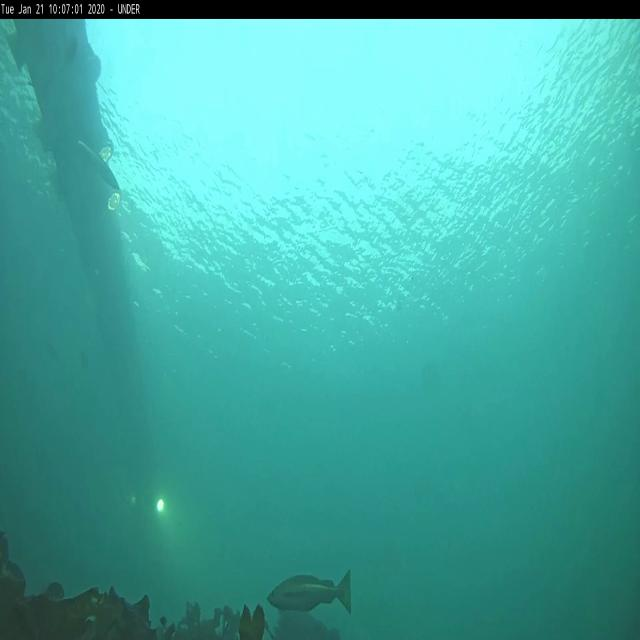

In [107]:
Image.open(files[3])

### Annotations

In [108]:
# مسیر فایل‌های XML در هر دو پوشه train و valid
train_xmls = glob.glob(os.path.join(DATA_DIR, 'train', '*.xml'))
valid_xmls = glob.glob(os.path.join(DATA_DIR, 'valid', '*.xml'))

# ترکیب هر دو لیست
anno_files = train_xmls + valid_xmls

# نمایش چند نمونه
print([os.path.basename(f) for f in anno_files][:7])


['881_png.rf.a9d8cc00e9522b8e7fca302c44516e15.xml', '609_png.rf.71155561209d46822d238361ccf00977.xml', '1867_png.rf.158504767e0c1c729eb956e284226bc5.xml', '1260_png.rf.a17d5b6f475a669d9e25dde83ce6a2cb.xml', '1160_png.rf.34dfa2dfbafc88ab4ccf92d4bde83886.xml', '1086_png.rf.f7581982f5765b920ee8b023b2efb628.xml', '220_png.rf.2b23b31bee7061e6670b6e65d9abc752.xml']


In [109]:
#filename = f'{anno_dir}/{anno_files[0]}'
# حالا برای فایل اول (مثلاً اولین XML)
filename = anno_files[0]  # مسیر کامل فایل XML اول
print(open(filename, 'r').read())  # خوندن و چاپ محتوای فایل XML

<annotation>
	<folder></folder>
	<filename>881_png.rf.a9d8cc00e9522b8e7fca302c44516e15.jpg</filename>
	<path>881_png.rf.a9d8cc00e9522b8e7fca302c44516e15.jpg</path>
	<source>
		<database>roboflow.com</database>
	</source>
	<size>
		<width>640</width>
		<height>640</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>0</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<occluded>0</occluded>
		<bndbox>
			<xmin>435</xmin>
			<xmax>467</xmax>
			<ymin>99</ymin>
			<ymax>156</ymax>
		</bndbox>
	</object>
	<object>
		<name>0</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<occluded>0</occluded>
		<bndbox>
			<xmin>475</xmin>
			<xmax>513</xmax>
			<ymin>61</ymin>
			<ymax>83</ymax>
		</bndbox>
	</object>
	<object>
		<name>0</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<occluded>0</occluded>
		<bndbox>
			<xmin>367</xmin>
			<xmax>387</xmax

Creat a simple class for images

In [110]:
#چون فایل اطلاعات عکس ها و عکس ها با هم قاطی اند و پوشه بندی جداگانه نشده اند
#عکس ها یعنی عکس هر ماهی تو پوشه خودش، اول یه کلاس ساده میسازیم کهفقط عکس ها رو لیست کنه بعد میفرستیم به کلاسFishdataset
from torchvision.datasets.folder import default_loader

class SimpleImageDataset:
    def __init__(self, root):
        self.imgs = [(f, 0) for f in glob.glob(os.path.join(root, '*.jpg'))]
        self.classes = ['fish']  # مقدار اولیه فقط


### Create validation data

In [111]:
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split=0.2, ext='jpg')

### Fish Dataset

In [112]:
def bbox_to_r1c1r2c2(bbox):
    x = bbox['x']
    y = bbox['y']
    w = bbox['width']
    h = bbox['height']
    return [y, x, y + h, x + w]  # [r1, c1, r2, c2]


In [113]:
# class FishDataset(Dataset):
#     def __init__(self, ds, bboxes, classes, class_to_idx, sz=299):
#         """
#         ds: مجموعه تصاویر
#         bboxes: دیکشنری حاوی مختصات جعبه‌های محدود کننده
#         classes: لیست کلاس‌ها
#         class_to_idx: دیکشنری که نام کلاس‌ها را به اندیس تبدیل می‌کند
#         sz: اندازه تصویر
#         """
#         self.imgs = ds.imgs
#         self.classes = classes
#         self.bboxes = bboxes
#         self.class_to_idx = class_to_idx
#         self.sz = sz
#         self.tfms = transforms.Compose([
#             transforms.Resize((sz, sz)),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#         ])

#     def __getitem__(self, index):
#         img, _ = self.imgs[index]
#         img_name = os.path.basename(img)

#         if img_name in self.bboxes:
#             bbox_info = self.bboxes[img_name]
#             bbox = bbox_to_r1c1r2c2(bbox_info)  # استفاده از تابع bbox_to_r1c1r2c2
#             lbl = self.class_to_idx[str(bbox_info['class'])]
#         else:
#             bbox = [0., 0., 0., 0.]
#             lbl = 0

#         image = Image.open(img).convert('RGB')
#         w, h = image.size
#         w_scale = self.sz / w
#         h_scale = self.sz / h

#         image = self.tfms(image)

#         # مقیاس‌بندی جعبه محدود کننده (bbox)
#         bbox[0] = (bbox[0] / h) * h_scale
#         bbox[1] = (bbox[1] / w) * w_scale
#         bbox[2] = (bbox[2] / h) * h_scale
#         bbox[3] = (bbox[3] / w) * w_scale

#         return image, lbl, torch.tensor(bbox, dtype=torch.float32), (w, h)

#     def __len__(self):
#         return len(self.imgs)


In [114]:

class FishDataset(Dataset):
    def __init__(self, ds, bboxes, classes, class_to_idx, sz=299):
        """
        ds: مجموعه تصاویر
        bboxes: دیکشنری شامل 'boxes' و 'labels' برای هر تصویر
        classes: لیست کلاس‌ها
        class_to_idx: دیکشنری نگاشت نام کلاس به اندیس
        sz: اندازه نهایی تصویر
        """
        self.imgs = ds.imgs
        self.classes = classes
        self.bboxes = bboxes
        self.class_to_idx = class_to_idx
        self.sz = sz
        self.tfms = transforms.Compose([
            transforms.Resize((sz, sz)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        img, _ = self.imgs[index]
        img_name = os.path.basename(img)

        image = Image.open(img).convert('RGB')
        w, h = image.size
        w_scale = self.sz / w
        h_scale = self.sz / h

        image = self.tfms(image)

        boxes = []
        labels = []

        if img_name in self.bboxes:
            bbox_info = self.bboxes[img_name]
            for box, label in zip(bbox_info['boxes'], bbox_info['labels']):
                # تبدیل به فرمت [y1, x1, y2, x2]
                y1 = (box[1] / h) * h_scale
                x1 = (box[0] / w) * w_scale
                y2 = (box[3] / h) * h_scale
                x2 = (box[2] / w) * w_scale
                boxes.append([y1, x1, y2, x2])
                labels.append(label if isinstance(label, int) else self.class_to_idx[str(label)])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        return image, labels, boxes, (w, h)

    def __len__(self):
        return len(self.imgs)


### Training and Validation dataset

In [115]:
def extract_classes_from_xml(dataset_dirs):
    """
    dataset_dirs: لیستی از مسیرها به پوشه‌های train و valid
    خروجی: دیکشنری class_to_idx
    """
    classes = set()

    for dataset_dir in dataset_dirs:
        for file in os.listdir(dataset_dir):
            if file.endswith('.xml'):
                xml_path = os.path.join(dataset_dir, file)
                try:
                    tree = ET.parse(xml_path)
                    root = tree.getroot()
                    for obj in root.findall('object'):
                        name = obj.find('name').text
                        classes.add(name)
                except Exception as e:
                    print(f"خطا در فایل {file}: {e}")

    sorted_classes = sorted(list(classes))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted_classes)}
    return class_to_idx


In [116]:
def collate_fn(batch):
    imgs, lbls, bbs, sizes = zip(*batch)
    imgs = torch.stack(imgs, 0)
    return imgs, lbls, bbs, sizes


In [118]:
# # خواندن annotation و کلاس‌ها
# bb_json = read_all_annotations(train_dir)

# # حالا باید لیست کلاس‌ها رو از داخل `labels` استخراج کنی
# all_classes = sorted(list(set(label for v in bb_json.values() for label in v['labels'])))

# # دیتاست و دیتالودر
# train_data = SimpleImageDataset(train_dir)
# train_ds = FishDataset(train_data, bboxes=bb_json, classes=all_classes, sz=sz)
# #train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
# train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn)


# # اعتبارسنجی
# valid_data = SimpleImageDataset(valid_dir)
# valid_ds = FishDataset(valid_data, bboxes=bb_json, classes=all_classes, sz=sz)
# #valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)
# valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn)

# خواندن annotation و کلاس‌ها
bb_json = read_all_annotations(train_dir)

# استخراج لیست یکتا از کلاس‌ها
all_classes = sorted(list(set(label for v in bb_json.values() for label in v['labels'])))

# ساخت دیکشنری class_to_idx
class_to_idx = {cls: i for i, cls in enumerate(all_classes)}

# دیتاست و دیتالودر آموزش
train_data = SimpleImageDataset(train_dir)
train_ds = FishDataset(train_data, bboxes=bb_json, classes=all_classes, class_to_idx=class_to_idx, sz=sz)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn)

# دیتاست و دیتالودر اعتبارسنجی
valid_data = SimpleImageDataset(valid_dir)
valid_ds = FishDataset(valid_data, bboxes=bb_json, classes=all_classes, class_to_idx=class_to_idx, sz=sz)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn)


### Visulaize data

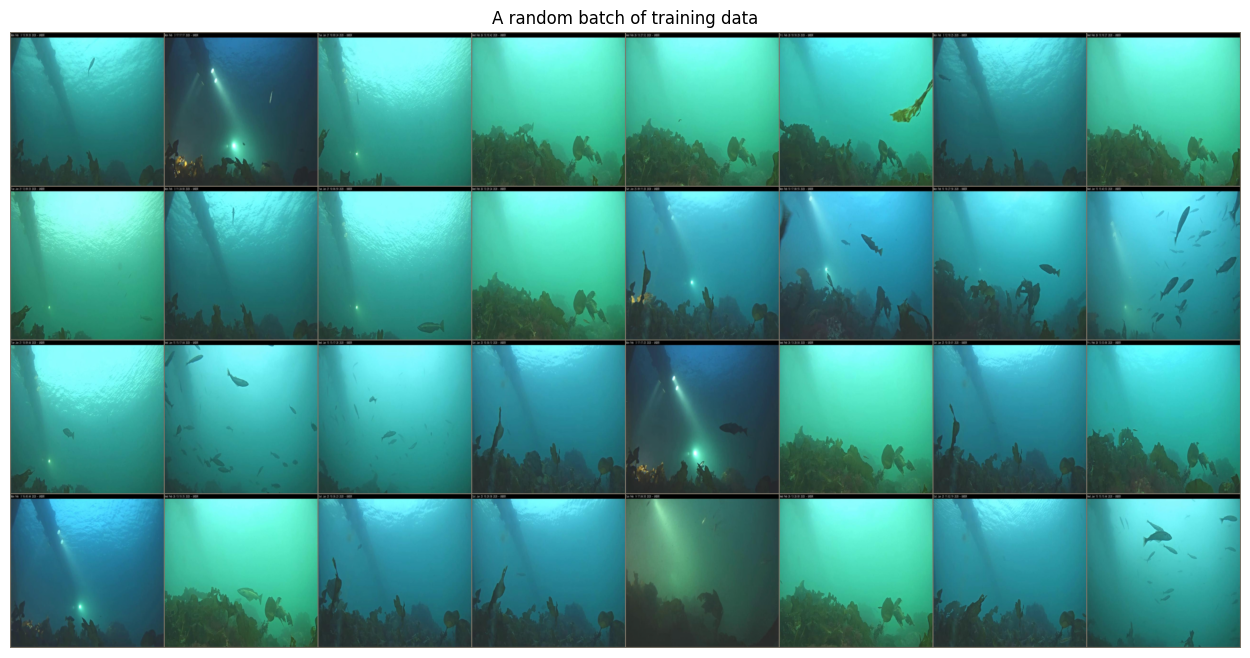

In [131]:
# # # dataiter = iter(train_dl)
# # # imgs, lbls, bbs, sizes = next(dataiter)
# # # img = torchvision.utils.make_grid(imgs, nrow=8)
# # # plt.figure(figsize=(16, 8))
# # # imshow(img, title='A random batch of training data')


# # dataiter = iter(train_dl)
# # imgs, lbls, bbs, sizes = next(dataiter)

# # # چون در dataset ممکن است چندین bbox برای هر تصویر داشته باشیم، باید این قسمت را مدیریت کنیم
# # # برای نمونه، می‌توانیم bounding boxes را برای هر تصویر در یک لیست نمایش دهیم

# # # ایجاد grid برای تصاویر
# # img = torchvision.utils.make_grid(imgs, nrow=8)

# # # آماده‌سازی تصاویر برای نمایش
# # plt.figure(figsize=(16, 8))
# # imshow(img, title='A random batch of training data')

# # # نمایش جعبه‌های محدودکننده برای هر تصویر (اگر نیاز است)
# # for i in range(len(imgs)):
# #     img_bbox = bbs[i].numpy()  # تبدیل bbs به آرایه numpy
# #     for bbox in img_bbox:
# #         # از متغیرهای bbox برای رسم مستطیل استفاده می‌کنیم
# #         plt.gca().add_patch(plt.Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0], fill=False, color='red', linewidth=2))

# # plt.show()


# dataiter = iter(train_dl)
# imgs, lbls, bbs, sizes = next(dataiter)

# # ایجاد grid برای تصاویر
# img = torchvision.utils.make_grid(imgs, nrow=8)

# # آماده‌سازی تصاویر برای نمایش
# plt.figure(figsize=(16, 8))
# imshow(img, title='A random batch of training data')

# # رسم جعبه‌های محدودکننده برای هر تصویر
# for i in range(len(imgs)):
#     img_bbox = bbs[i]
#     if img_bbox.ndim == 1:
#         img_bbox = img_bbox.unsqueeze(0)  # تبدیل به شکل (1, 4) برای هماهنگی

#     for bbox in img_bbox:
#         bbox = bbox.numpy()
#         plt.gca().add_patch(plt.Rectangle(
#             (bbox[1], bbox[0]),                # (x, y)
#             bbox[3] - bbox[1],                 # عرض
#             bbox[2] - bbox[0],                 # ارتفاع
#             fill=False, color='red', linewidth=2
#         ))

# plt.show()


# dataiter = iter(train_dl)
# imgs, lbls, bbs, sizes = next(dataiter)

# # ایجاد grid برای تصاویر
# img = torchvision.utils.make_grid(imgs, nrow=8)

# # آماده‌سازی تصاویر برای نمایش
# plt.figure(figsize=(16, 8))
# imshow(img, title='A random batch of training data')

# # رسم جعبه‌های محدودکننده برای هر تصویر
# for i in range(len(imgs)):
#     img_bbox = bbs[i]

#     # اطمینان از هماهنگی ابعاد (در صورتی که bbox یک بعدی باشد)
#     if img_bbox.ndimension() == 1:
#         img_bbox = img_bbox.unsqueeze(0)

#     # رسم باکس‌ها برای هر تصویر
#     for bbox in img_bbox:
#         bbox = bbox.numpy()  # تبدیل به numpy array
#         plt.gca().add_patch(plt.Rectangle(
#             (bbox[1], bbox[0]),                # (xmin, ymin)
#             bbox[3] - bbox[1],                 # عرض
#             bbox[2] - bbox[0],                 # ارتفاع
#             fill=False, color='red', linewidth=2
#         ))

# plt.show()

# dataiter = iter(train_dl)
# imgs, lbls, bbs, sizes = next(dataiter)

# # ایجاد grid برای تصاویر
# img = torchvision.utils.make_grid(imgs, nrow=8)

# # آماده‌سازی تصاویر برای نمایش
# plt.figure(figsize=(16, 8))
# imshow(img, title='A random batch of training data')

# # رسم جعبه‌های محدودکننده برای هر تصویر
# for i in range(len(imgs)):
#     img_bbox = bbs[i]  # جعبه‌های محدودکننده مربوط به تصویر i
#     img_bbox = img_bbox.numpy()  # تبدیل bbox به numpy array

#     # رسم باکس‌ها برای هر تصویر
#     for bbox in img_bbox:
#         # اینجا باید اطمینان حاصل کنیم که bbox به صورت (xmin, ymin, xmax, ymax) باشد
#         plt.gca().add_patch(plt.Rectangle(
#             (bbox[1], bbox[0]),                # (xmin, ymin)
#             bbox[3] - bbox[1],                 # عرض (xmax - xmin)
#             bbox[2] - bbox[0],                 # ارتفاع (ymax - ymin)
#             fill=False, color='red', linewidth=2
#         ))

# plt.show()


dataiter = iter(train_dl)
imgs, lbls, bbs, sizes = next(dataiter)

# ایجاد grid برای تصاویر
img = torchvision.utils.make_grid(imgs, nrow=8)

# آماده‌سازی تصاویر برای نمایش
plt.figure(figsize=(16, 8))
imshow(img, title='A random batch of training data')

# نمایش تصاویر بدون رسم جعبه‌های محدودکننده
plt.show()



torch.Size([3, 299, 299])
lbl shape: torch.Size([2])
برچسب چندکلاسه است: tensor([0, 0])
[[0.4328784  0.10365722 0.45112792 0.12774658]
 [0.39418945 0.13358642 0.40659913 0.14453614]]


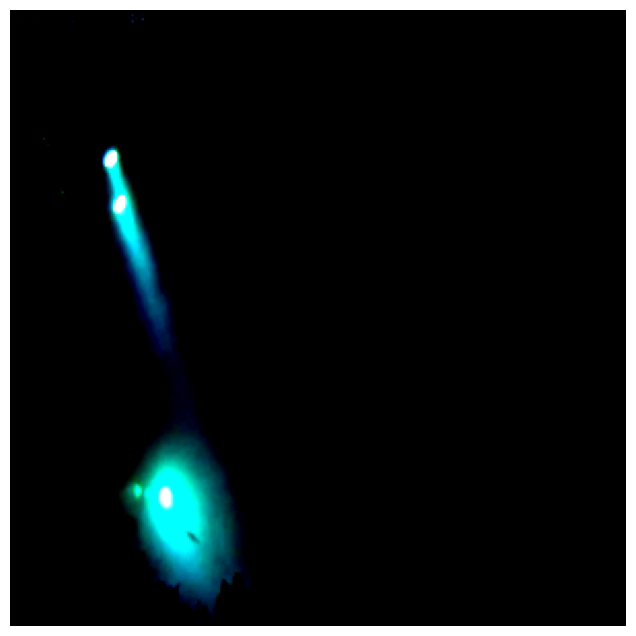

In [142]:
# # get one specific data from training data
# img, lbl, bb, (w, h) = train_ds[10]

# # print size, label, and bounding box
# print(img.size())
# print(lbl, ':', train_ds.classes[lbl])
# print(bb.numpy())

# # plot image and bounding box
# plot_bbox(img, bb, w, h)
# گرفتن یک نمونه خاص از داده‌های آموزشی
img, lbl, bb, (w, h) = train_ds[10]

# چاپ اندازه، برچسب و جعبه محدودکننده
print(img.size())
print(f"lbl shape: {lbl.shape}")  # نمایش ابعاد lbl برای بررسی بیشتر

# در صورتی که lbl یک tensor چند عنصری باشد، از گزینه‌ای برای تبدیل آن استفاده کنید
if lbl.numel() == 1:
    lbl = lbl.item()  # تبدیل lbl به یک عدد صحیح
    print(lbl, ':', train_ds.classes[lbl])
else:
    print("برچسب چندکلاسه است:", lbl)

print(bb.numpy())

# رسم تصویر و جعبه محدودکننده
plt.figure(figsize=(8, 8))
plt.imshow(img.permute(1, 2, 0))  # تبدیل تصویر برای نمایش صحیح
plt.axis('off')  # حذف محورهای تصویر

# رسم جعبه محدودکننده
bb = bb.numpy()  # تبدیل bbox به numpy array
for bbox in bb:
    plt.gca().add_patch(plt.Rectangle(
        (bbox[1], bbox[0]),                # (xmin, ymin)
        bbox[3] - bbox[1],                 # عرض (xmax - xmin)
        bbox[2] - bbox[0],                 # ارتفاع (ymax - ymin)
        fill=False, color='red', linewidth=2
    ))

plt.show()

## Classification with Localization

<img src='imgs/localization.png' width='90%'/>

### Model

In [ ]:
class ClassifierLocalizer(nn.Module):
    def __init__(self, model_name, num_classes=8):
        super(ClassifierLocalizer, self).__init__()
        self.num_classes = num_classes

        # create cnn model
        model = get_model(model_name, num_classes)

        # remove fc layers and add a new fc layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes + 4) # classifier + localizer
        self.model = model

    def forward(self, x):
        x = self.model(x)                    # extract features from CNN
        scores = x[:, :self.num_classes]     # class scores
        coords = x[:, self.num_classes:]     # bb corners coordinates
        return scores, torch.sigmoid(coords)     # sigmoid output is in [0, 1]

### Loss Function

Loss function has two parts:
- Cross Entropy Loss (for classification)
- Sum of Squared Errors (for regression)

In [ ]:
class LocalizationLoss(nn.Module):
    def __init__(self, num_classes=8):
        super(LocalizationLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(reduction='sum')
        self.mse_loss = nn.MSELoss(reduction='sum')

    def forward(self, scores, locs, labels, bboxes):
        # Cross Entropy (for classification)
        loss_cls = self.ce_loss(scores, labels)

        # Sum of Squared errors (for corner points)
        loss_r1 = self.mse_loss(locs[:, 0], bboxes[:, 0]) / 2.0
        loss_c1 = self.mse_loss(locs[:, 1], bboxes[:, 1]) / 2.0
        loss_r2 = self.mse_loss(locs[:, 2], bboxes[:, 2]) / 2.0
        loss_c2 = self.mse_loss(locs[:, 3], bboxes[:, 3]) / 2.0

        return loss_cls, loss_r1 + loss_c1 + loss_r2 + loss_c2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ClassifierLocalizer(model_name)
model = model.to(device)

criterion = LocalizationLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

In [ ]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=3)

Epoch 1/3
----------


/home/razavi/Documents/mygithub/DeepLearning/Deep_Learning_in_Python_2018/venv/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  train Loss: 34.05300 (21.55690 + 1.24961), Acc: 0.79418
  valid Loss: 7.42997 (6.20697 + 0.12230), Acc: 0.94967

Epoch 2/3
----------
  train Loss: 3.62773 (2.52090 + 0.11068), Acc: 0.98445
  valid Loss: 5.16499 (4.20819 + 0.09568), Acc: 0.96954

Epoch 3/3
----------
  train Loss: 1.60140 (0.79708 + 0.08043), Acc: 0.99570
  valid Loss: 3.96232 (3.27223 + 0.06901), Acc: 0.97616

Training complete in 6m 9s
Best val Acc: 0.9762


### Predicting bounding boxes

In [ ]:
# load weights
# model.load_state_dict(torch.load('models/resnet34-299-loc-epoch-9-acc-0.97483.pth'))

5 : OTHER


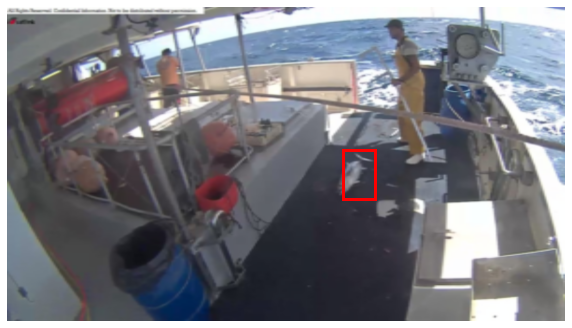

In [ ]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)
imgs, lbls, bbs, sizes = next(iter(valid_dl))
scores, locs = model(imgs.to(device))

scores = scores.detach().cpu().numpy()
locs = locs.detach().cpu().numpy()

pred_lbl = np.argmax(scores, axis=1)[0]
pred_bb = locs[0].tolist()

print(pred_lbl, ':', valid_ds.classes[pred_lbl])
w, h = sizes[0].numpy()[0], sizes[1].numpy()[0]

plot_bbox(imgs[0], pred_bb, w, h)

## Other applications

### Key point detection

<img src='imgs/key_points.png' width='80%'/>

### Pose estimation

<img src='imgs/pose.png' width='80%'/>